The data used this analysis is from 27000 movies data over last 10 years, scrapped from IMBD website using html parser lxml. We have cleaned and subsetted the data to include US based English language movies for which gross_revenue exists, leaving 2851 movies.  

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt


df=pd.read_csv('Data/movies_cleanest.csv')
print('shape of the data frame is', df.shape)
print(df.head())

shape of the data frame is (2851, 20)
                                         title        director  \
0                               The Accountant  Gavin O'Connor   
1                        The Girl on the Train     Tate Taylor   
2                                Suicide Squad      David Ayer   
3                                Don't Breathe    Fede Alvarez   
4  Miss Peregrine's Home for Peculiar Children      Tim Burton   

                              writers  \
0                                       
1  Erin Cressida Wilson;Paula Hawkins   
2                                       
3          Fede Alvarez;Rodo Sayagues   
4           Ransom Riggs;Jane Goldman   

                                        actors  \
0       Ben Affleck;Anna Kendrick;J.K. Simmons   
1   Emily Blunt;Haley Bennett;Rebecca Ferguson   
2          Will Smith;Jared Leto;Margot Robbie   
3        Stephen Lang;Jane Levy;Dylan Minnette   
4  Eva Green;Asa Butterfield;Samuel L. Jackson   

                 

In [3]:
df['Date_released'] = pd.to_datetime(df.Date_released, format ='%Y-%m-%d')

#print((df.Date_released).dtype)

# subset the data frame to columns of interest
my_df = df[['title', 'Date_released', 'genres', 'runtime_mins', 'budget', 'opening_weekend_revenue', 'gross_revenue']]
#print(my_df.isnull().sum())
my_df= my_df.dropna() # drop all rows with a NA
print(my_df.shape)

(1658, 7)


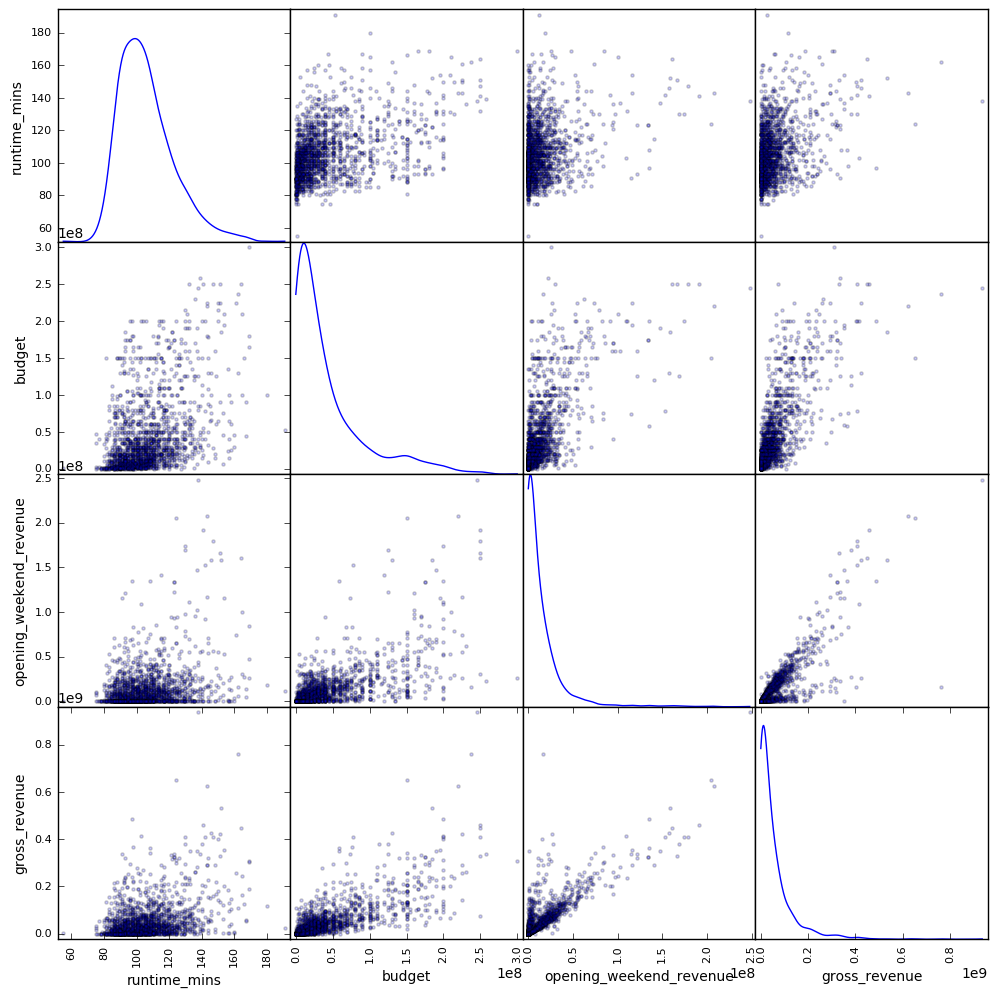

In [4]:
# scatter matrix for all the numeric variables
from pandas.tools.plotting import scatter_matrix
scatter_matrix(my_df, alpha=0.2, figsize=(12, 12), diagonal='kde')
plt.show()


### Analyse the revenue by release date

In [5]:
# Trends in the revenues over the years
my_df.is_copy =False # to avoid the SettingWithCopyWarning 

grouped = my_df.groupby(['Date_released']).agg({'budget':np.mean,'gross_revenue': np.mean, 'opening_weekend_revenue': np.mean}).reset_index()

import calendar # to convert months and weekdays from numbers to name

grouped['month']=grouped['Date_released'].dt.month # create months column
grouped['month']=grouped['month'].apply(lambda x: calendar.month_abbr[x]) # convert month from integer to month name
gpby_month =grouped.groupby(['month']).agg({'budget':np.mean,'gross_revenue': np.mean, 'opening_weekend_revenue': np.mean})

print(gpby_month.head())

grouped['week']=grouped['Date_released'].dt.dayofweek # create weeks column
grouped['week']=grouped['week'].apply(lambda x: calendar.day_name[x]) 
gpby_week = grouped.groupby(['week']).agg({'budget':np.mean,'gross_revenue': np.mean, 'opening_weekend_revenue': np.mean})


             budget  opening_weekend_revenue  gross_revenue
month                                                      
Apr    2.918014e+07             1.290918e+07   4.158896e+07
Aug    3.196408e+07             1.252163e+07   4.451768e+07
Dec    5.805905e+07             1.405136e+07   9.128744e+07
Feb    3.475972e+07             1.291718e+07   4.186762e+07
Jan    2.063821e+07             6.754191e+06   2.818537e+07


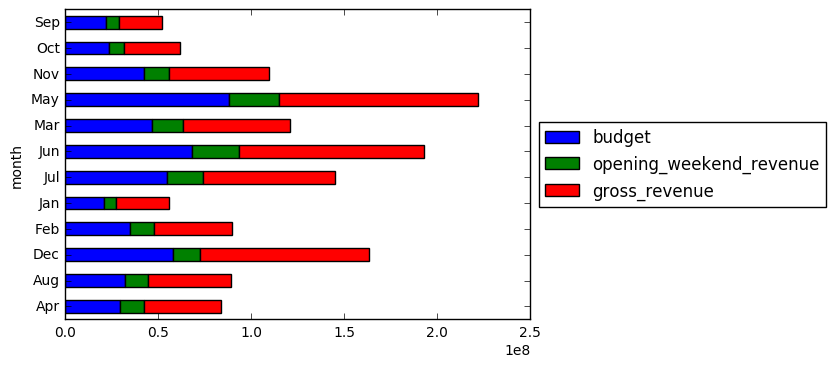

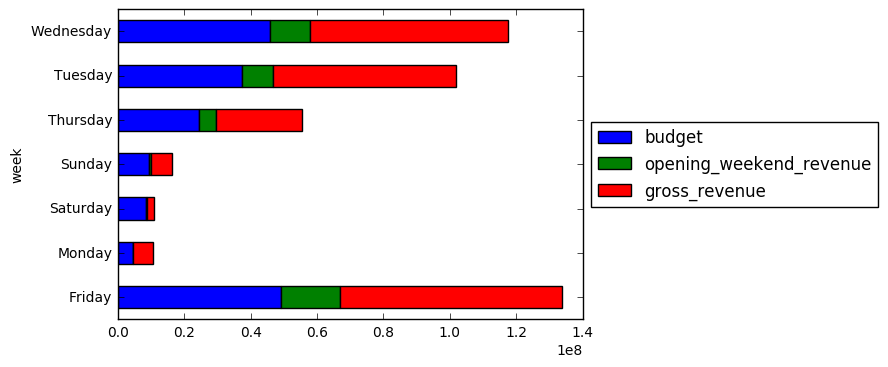

In [6]:
gpby_month.plot.barh(stacked=True).legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

gpby_week.plot.barh(stacked=True).legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### Impact of user ratings and meta score on the revenue 

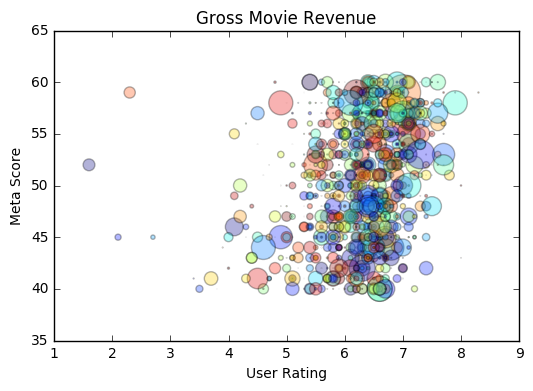

In [7]:
df_ratings = df[['user_rating_10', 'meta_score_100', 'gross_revenue']]

df_ratings = df_ratings.dropna()
x= df_ratings.user_rating_10
y= df_ratings.meta_score_100
area = df_ratings.gross_revenue.values/1000000
colors = np.random.rand(df_ratings.shape[0])
plt.scatter(x, y, s=area, c=colors, alpha=0.3)
plt.xlabel('User Rating'); plt.ylabel('Meta Score'); plt.title('Gross Movie Revenue')
plt.show()


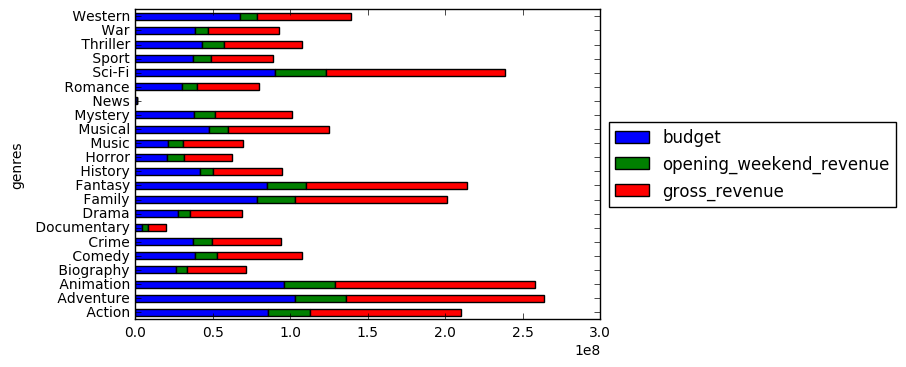

In [8]:
# Revenue and Genre

s = my_df['genres'].str.split(';').apply(pd.Series, 1).stack()

s.index =s.index.droplevel(-1) # drop the second level to line up with my_df index
s.name = 'genres' # needed for the join with my_df
df_genre = df.drop(my_df.columns[2], axis =1) # delete the genres column from df 

df_genre = df_genre.join(s)

#print(df_genre.shape)

gpby_genres = df_genre.groupby(['genres']).agg({'budget':np.mean,'gross_revenue': np.mean, 'opening_weekend_revenue': np.mean})
#print(gpby_genres.head())

gpby_genres.plot.barh(stacked =True).legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


### Prediction model

We build and evaluate a prediction model using the numeric features such as date of release, budget, user ratings. We exclude meta score, because there more than 60% missing values and its effect on the revenue is the least substantial. 

In [9]:
df_M = df[['Date_released', 'runtime_mins', 'user_rating_10', 'budget', 'opening_weekend_revenue', 'gross_revenue']]
#print(df_M.shape)
#print(df_M.head())
df_M.is_copy = False # to supress CopyWarningMessage

# convert Date to numeric feature
df_M.Date_released = df_M.Date_released.apply(lambda x: x.toordinal()) # to ordinal
df_M.Date_released = (df_M.Date_released - df_M.Date_released.min()).astype(np.float64) # number of days from the earliest release date

# remove duplicate rows
df_M.drop_duplicates(inplace=True) # 36 duplicate rows removed

df_M = df_M.fillna(df.mean()) # fill NAs
df_M = np.log1p(df_M) # log tranform to create more normal features and deal with the heteroscedasticity 
df_M = df_M.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x))) #normalize

#print(df_M.head())

y= df_M['gross_revenue']  # response variable
X= df_M.drop('gross_revenue', 1) # predictors 



In [10]:
# split data into train and test sets
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [11]:
# Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)


lin_model=LinearRegression()
rmse_linear = rmse_cv(lin_model).mean()
r2_linear = cross_val_score(lin_model, X_train, y_train, scoring='r2', cv=5).mean()

print('For Linear Regression, RMSE is ', rmse_linear, 'and R^2 is ', r2_linear)

lin_fit =lin_model.fit(X_train, y_train)
lin_model.coef_ # coefficients

pred_lin = pd.DataFrame({"pred":lin_fit.predict(X_train), "true":y_train})
pred_lin["residuals"] = pred_lin["true"] - pred_lin["pred"]


For Linear Regression, RMSE is  0.0766224067536 and R^2 is  0.867542055552


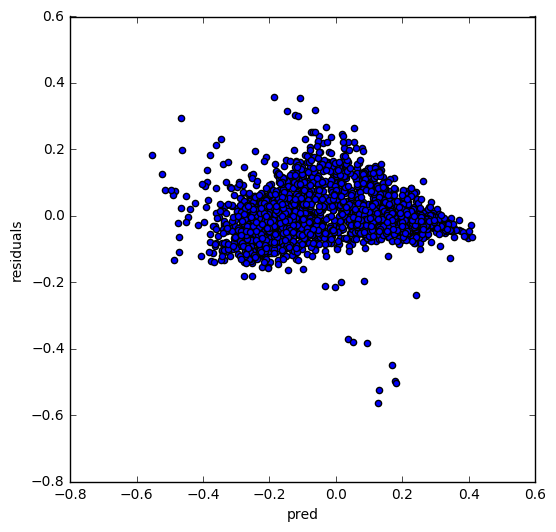

In [12]:
# residual plot
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
pred_lin.plot(x = "pred", y = "residuals", kind = "scatter")
plt.show()

In [13]:
# SVR
from sklearn.svm import SVR # support vector regression
#svr_model = SVR(kernel ='poly', degree = 2, C=1.0, epsilon=0.2) # with ploynomial kernel of degree 3
svr_model = SVR(C=1.0, epsilon=0.2)

rmse_svr = rmse_cv(svr_model).mean()

svr_model.fit(X_train, y_train)
r2_svr = svr_model.score(X_train, y_train)
print('For SVR, RMSE is ', rmse_svr, 'and R^2 is ', r2_svr)

For SVR, RMSE is  0.0913577720263 and R^2 is  0.819589525243


Linear Regression performs better than SVR. We compute the RMSE on the test set.

In [14]:
# test set error
lin_model.fit(X_test, y_test)
y_pred = lin_model.predict(X_test)     
rmse = np.sqrt(sum((y_pred - y_test)**2) / len(y_pred))  
print('Rmse on the test set is' , rmse)


Rmse on the test set is 0.0728239477699
